In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [7]:
data = pd.read_csv('C:/Users/solom/Desktop/BAYES/dielectron.csv')

data = data.dropna()
data = data[(data['Q1'] + data['Q2']) == 0]

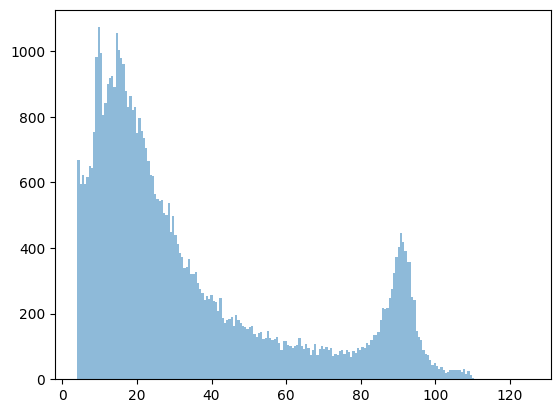

In [8]:
M_data = data['M'].values
plt.hist(M_data, bins=200, range=(4, 125), alpha=0.5, label='Data')

hist, bin_edges = np.histogram(M_data, bins=200, range=(4,125))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

y = hist
x = bin_centers

In [9]:
def model(x, a1, mu1, sigma1, a2, mu2, sigma2, b, k):
    gaussian1 = a1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2))
    gaussian2 = a2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2))
    background = b * np.exp(-k * x)
    return gaussian1 + gaussian2 + background

In [10]:
def log_likelihood_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y):
    prediction = model(x, a1, mu1, sigma1, a2, mu2, sigma2, b, k)

    n = len(y)
    # log of the PDF of a multivariate Gaussian
    return (
        -0.5 * np.sum((y - prediction)**2/sigma_y**2)  # Exponent
        - n/2*np.log(2*np.pi*sigma_y**2)               # Normalisation
    )

In [11]:
a1_prior = scipy.stats.norm(loc=410, scale=100)
mu1_prior = scipy.stats.norm(loc=91, scale=10)
sigma1_prior = scipy.stats.norm(loc=3, scale=3)

a2_prior = scipy.stats.norm(loc=700, scale=200)
mu2_prior = scipy.stats.norm(loc=15, scale=10)
sigma2_prior = scipy.stats.norm(loc=7.5, scale=3)

b_prior = scipy.stats.norm(loc=380, scale=150)
k_prior = scipy.stats.norm(loc=0.025, scale=0.015)

def log_prior_probability(a1, mu1, sigma1, a2, mu2, sigma2, b, k):
    return a1_prior.logpdf(a1) + mu1_prior.logpdf(mu1)+ sigma1_prior.logpdf(sigma1) + a2_prior.logpdf(a2) + mu2_prior.logpdf(mu2) + sigma2_prior.logpdf(sigma2) + b_prior.logpdf(b) + k_prior.logpdf(k)

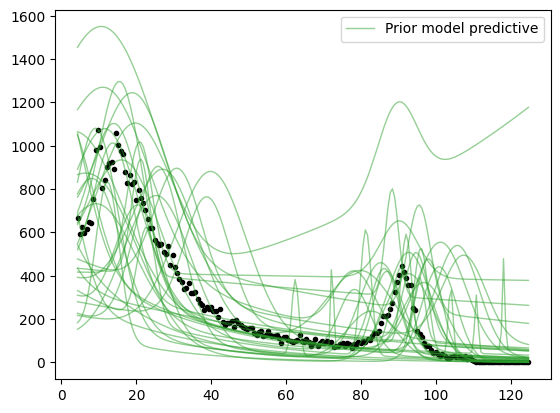

In [12]:
def sample_prior(n_sample):
    """Sample n_sample times from the prior distribution."""
    return np.vstack((a1_prior.rvs(n_sample), mu1_prior.rvs(n_sample), sigma1_prior.rvs(n_sample), a2_prior.rvs(n_sample),
                     mu2_prior.rvs(n_sample), sigma2_prior.rvs(n_sample), b_prior.rvs(n_sample), k_prior.rvs(n_sample))).T

# Fix the pseudo random number generator seed for reproducibility
#np.random.seed(1)

# Evaluate the model at the prior sample parameters
prior_model_predictive = np.array(
    [model(x, *parameters) for parameters in sample_prior(n_sample=30)]
)



style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'black')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

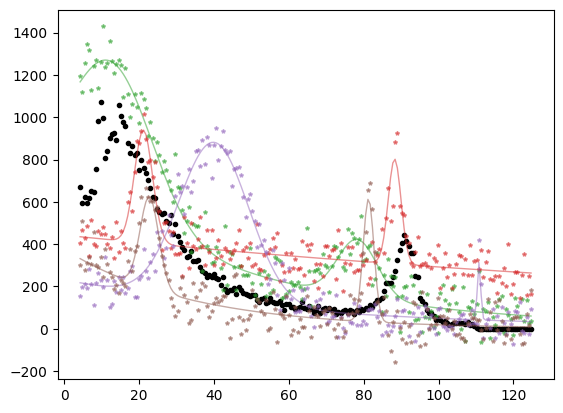

In [13]:
sigma_y = 70
prior_predictive = (
    prior_model_predictive
    + sigma_y*np.random.normal(size=prior_model_predictive.shape)
)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)

In [14]:
def log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y):
    return (
        log_likelihood_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y)
        + log_prior_probability(a1, mu1, sigma1, a2, mu2, sigma2, b, k)
    )
    
def negative_log_posterior(theta, x, sigma_y, y):
    a1, mu1, sigma1, a2, mu2, sigma2, b, k = theta
    return -log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y)

MAP_result = scipy.optimize.minimize(
    fun=negative_log_posterior,
    x0=(410, 91, 3, 700, 15, 7.5, 380, 0.025),
    args=(x, sigma_y, y)
)
MAP_results = MAP_result.x


print("MAP results")
print(MAP_results)


MAP results
[3.52507752e+02 9.08079297e+01 3.08488227e+00 5.77612150e+02
 1.62412847e+01 8.69111104e+00 4.87892161e+02 2.31631922e-02]


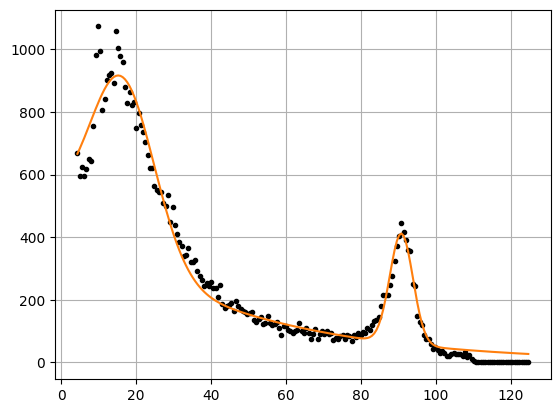

In [15]:
plt.plot(x, y, '.', color = 'black')
plt.plot(x, model(x, *MAP_results), c="C1", label="MAP model")
plt.grid()

In [16]:
import emcee

# emcee passes an array of values for the sampled parameters
# This wrapper just splits the array theta into m and b
def log_posterior_wrapper(theta, x, sigma_y, y):
    a1, mu1, sigma1, a2, mu2, sigma2, b, k = theta
    return log_posterior_probability(y, a1, mu1, sigma1, a2, mu2, sigma2, b, k, x, sigma_y)

# emcee requires some extra settings to run
n_param = 8       # Number of parameter we are sampling
n_walker = 20     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 5000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
theta_init = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) \
    + 0.1*np.random.normal(size=(n_walker, n_param))

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=log_posterior_wrapper,
    args=(x, sigma_y, y)
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)

In [17]:
chain = sampler.get_chain(discard=300, thin=10, flat=True)

Using matplotlib backend: inline


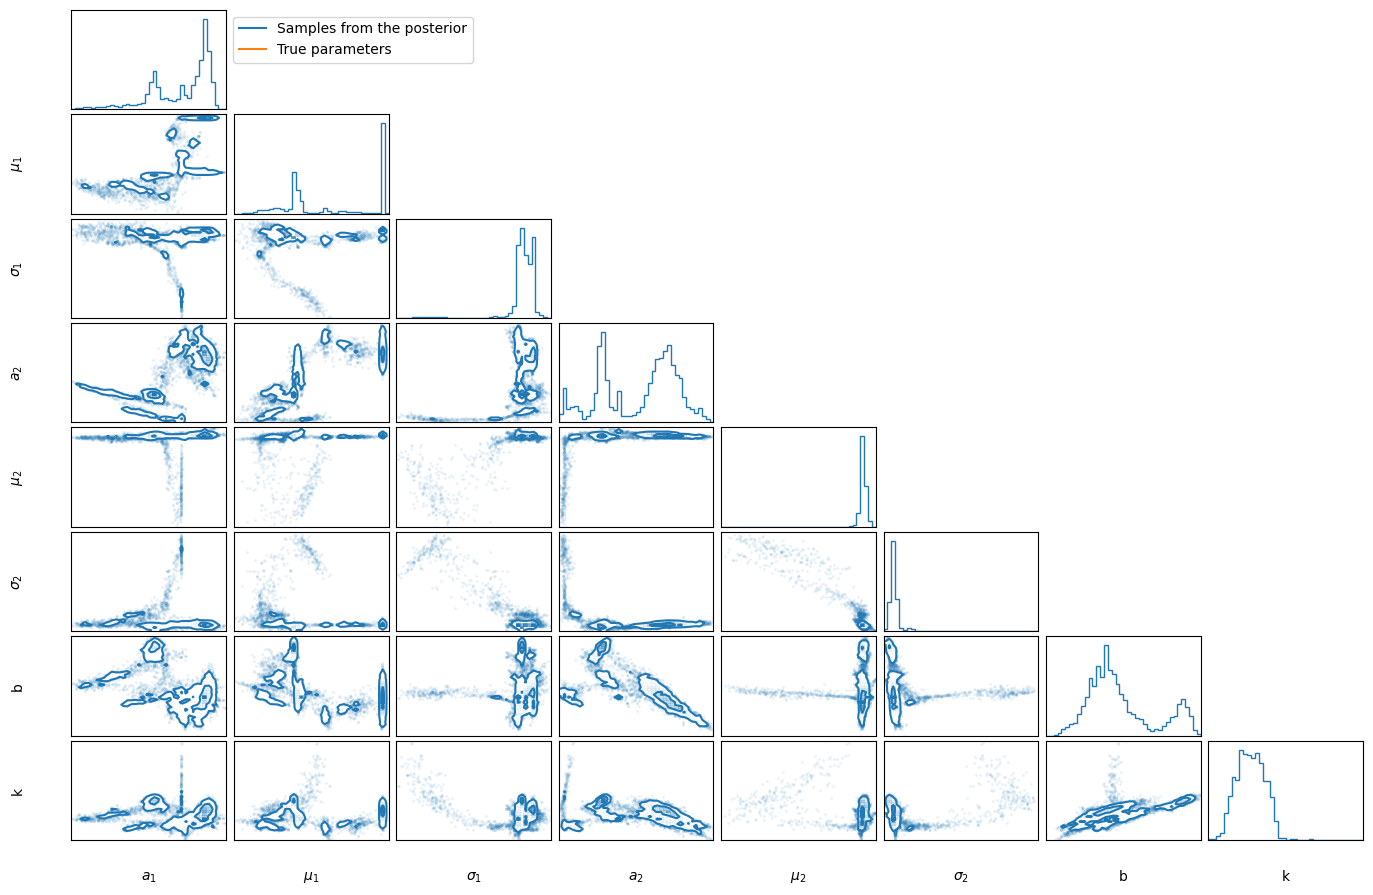

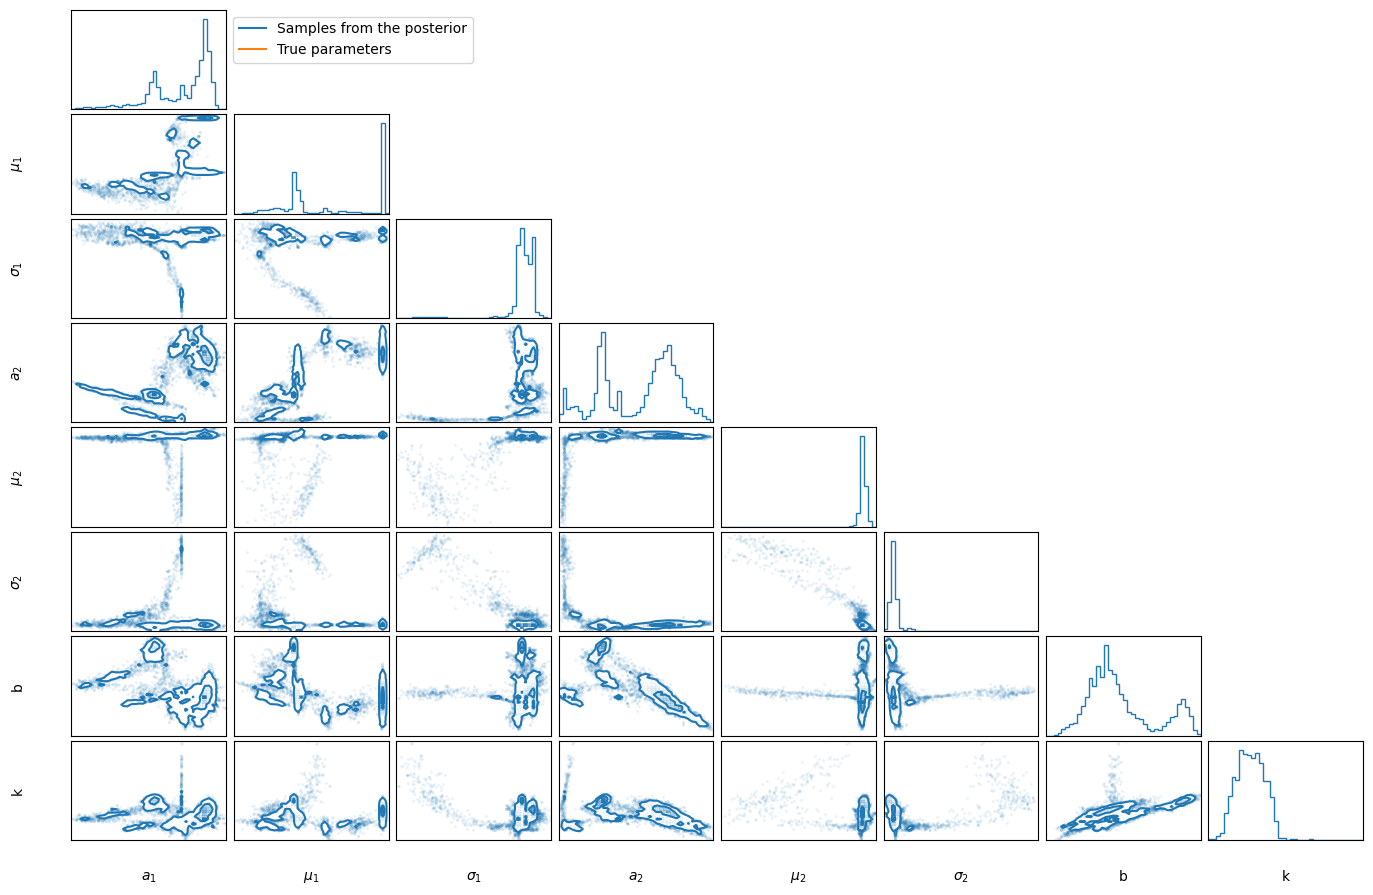

In [35]:
import corner
%matplotlib
fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=[r"$a_1$", r"$\mu_1$", r"$\sigma_1$", r"$a_2$", r"$\mu_2$", r"$\sigma_2$", "b", "k"],
    color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    # quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
)
fig.get_axes()[0].plot([], [], c="C0", label="Samples from the posterior")
fig.get_axes()[0].plot([], [], c="C1", label="True parameters")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))

# for ax in fig.get_axes():
#     ax.xaxis.label.set_size(12)  # Optional: Adjust font size if needed
#     ax.yaxis.label.set_size(12)
#     ax.xaxis.labelpad = 30       # Adjust label padding for x-axis
#     ax.yaxis.labelpad = 30       # Adjust label padding for y-axis

for ax in fig.get_axes():
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

fig.set_size_inches(14, 9)
fig
